In [1]:
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-63785c9f-160a-8467-f15e-cfff44a8953b)


### Helper functions

In [3]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-02-27 07:19:46--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-02-27 07:19:46 (79.0 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [4]:
from helper_functions import create_tensorboard_callback, plot_loss_curves, compare_historys

In [5]:
## Get Tensorflow datasets
import tensorflow_datasets as tfds

In [6]:
datasets_list = tfds.list_builders()
## Load in the data 
(train_data, test_data), ds_info = tfds.load(name="food101",
                                             split=["train", "validation"],
                                             shuffle_files=True,
                                             as_supervised=True,
                                             with_info=True) 

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteZDQUIT/food101-train.tfrecord*...:   0%|          …

Generating validation examples...:   0%|          | 0/25250 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/food101/2.0.0.incompleteZDQUIT/food101-validation.tfrecord*...:   0%|     …

Dataset food101 downloaded and prepared to /root/tensorflow_datasets/food101/2.0.0. Subsequent calls will reuse this data.


In [7]:
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [8]:
## Get the class name
class_names = ds_info.features["label"].names
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheesecake',
 'cheese_plate',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

**To become one with the data, we want to find:**
- Class names
- The shape of our input data (image tensors)
- The datatype of our input data,
- What the labels look like (one-hot encoded or label encoded)
- Do the labels match up with the class names?

In [9]:
## Take one sample of the train data
train_one_sample = train_data.take(1)
train_one_sample

<TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [10]:
## Output info about our training sample
for image, label in train_one_sample:
  print(f'''
    Image shape: {image.shape},
    Image datatypes: {image.dtype},
    Target class from Food101: {label},
    Class name: {class_names[label.numpy()]}
  
  ''')


    Image shape: (512, 512, 3),
    Image datatypes: <dtype: 'uint8'>,
    Target class from Food101: 81,
    Class name: ramen
  
  


(-0.5, 511.5, 511.5, -0.5)

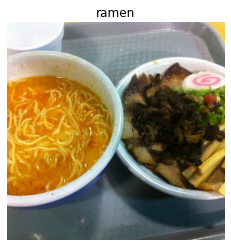

In [11]:
plt.imshow(image)
plt.title(class_names[label.numpy()])
plt.axis('off')

## Create preproccesing functions for our data

what we know:
- in uint8 datatyp
comprised of all different size tensors
- not scaled

what we want:
- data in float32
- normalized,
- batches, the same number of batches batches



In [12]:
def preprocess_img(image, label, img_shape=224):
  image = tf.image.resize(image, [img_shape, img_shape])
  # image /= 255. # Not with EfficientNet
  return tf.cast(image, tf.float32), label


### Batch and prepare datasets

In [13]:
## Map preprocessing function to training (and parallelize)
train_data = train_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE)

## SHuffle train_data and turn it into batches and prefetch it
train_data = train_data.shuffle(buffer_size=1000).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [14]:
## Test data
test_data = test_data.map(map_func=preprocess_img, num_parallel_calls=tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)


In [15]:
train_data,test_data

(<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

### Create some callbacks

In [16]:
## Create ModelCheckpoint callback to save a model's progress during training

checkpoint_path = "model_checkpoint/cp.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint_path,
                                                      monitor="val_acc",
                                                      save_best_only=True,
                                                      save_weights_only=True,
                                                      verbose=0)

### Setup mixed precision

In [17]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy("float32")

In [18]:
mixed_precision.global_policy()

<Policy "float32">

In [19]:
from tensorflow.keras import layers

# Create base model
input_shape = (224, 224, 3)
base_model = tf.keras.applications.EfficientNetB0(include_top=False)
base_model.trainable = False # freeze base model layers

# Create Functional model 
inputs = layers.Input(shape=input_shape, name="input_layer")
# Note: EfficientNetBX models have rescaling built-in but if your model didn't you could have a layer like below
# x = layers.Rescaling(1./255)(x)
x = base_model(inputs, training=False) # set base_model to inference mode only
x = layers.GlobalAveragePooling2D(name="pooling_layer")(x)
x = layers.Dense(len(class_names))(x) # want one output neuron per class 
# Separate activation of output layer so we can output float32 activations
outputs = layers.Activation("softmax", dtype=tf.float32, name="softmax_float32")(x) 
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(loss="sparse_categorical_crossentropy", # Use sparse_categorical_crossentropy when labels are *not* one-hot
              optimizer=tf.keras.optimizers.Adam(),
              metrics=["accuracy"])

16705208/16705208 [==============================] - 1s 0us/step


In [22]:
history = model.fit(train_data,
          epochs=10,
          steps_per_epoch=int(0.1 *len(train_data)),
          validation_data=test_data,
          validation_steps=int(0.1*len(test_data)),
          callbacks=[model_checkpoint])

Epoch 1/10
236/236 [==============================] - ETA: 0s - loss: 1.2628 - accuracy: 0.6737

236/236 [==============================] - 39s 142ms/step - loss: 1.2628 - accuracy: 0.6737 - val_loss: 1.1189 - val_accuracy: 0.6958
Epoch 2/10
236/236 [==============================] - ETA: 0s - loss: 1.1979 - accuracy: 0.6892

236/236 [==============================] - 26s 112ms/step - loss: 1.1979 - accuracy: 0.6892 - val_loss: 1.1119 - val_accuracy: 0.7002
Epoch 3/10
236/236 [==============================] - ETA: 0s - loss: 1.1891 - accuracy: 0.6916

236/236 [==============================] - 31s 131ms/step - loss: 1.1891 - accuracy: 0.6916 - val_loss: 1.0943 - val_accuracy: 0.7025
Epoch 4/10
236/236 [==============================] - ETA: 0s - loss: 1.1849 - accuracy: 0.6948

236/236 [==============================] - 27s 114ms/step - loss: 1.1849 - accuracy: 0.6948 - val_loss: 1.0897 - val_accuracy: 0.7041
Epoch 5/10
236/236 [==============================] - ETA: 0s - loss: 1.1974 - accuracy: 0.6860

236/236 [==============================] - 29s 123ms/step - loss: 1.1974 - accuracy: 0.6860 - val_loss: 1.0905 - val_accuracy: 0.7073
Epoch 6/10
236/236 [==============================] - ETA: 0s - loss: 1.2181 - accuracy: 0.6838

236/236 [==============================] - 30s 128ms/step - loss: 1.2181 - accuracy: 0.6838 - val_loss: 1.0720 - val_accuracy: 0.7089
Epoch 7/10
236/236 [==============================] - ETA: 0s - loss: 1.2196 - accuracy: 0.6803

236/236 [==============================] - 26s 112ms/step - loss: 1.2196 - accuracy: 0.6803 - val_loss: 1.0543 - val_accuracy: 0.7097
Epoch 8/10
236/236 [==============================] - ETA: 0s - loss: 1.1783 - accuracy: 0.6921

236/236 [==============================] - 27s 116ms/step - loss: 1.1783 - accuracy: 0.6921 - val_loss: 1.0610 - val_accuracy: 0.7097
Epoch 9/10
236/236 [==============================] - ETA: 0s - loss: 1.1612 - accuracy: 0.6993

236/236 [==============================] - 27s 113ms/step - loss: 1.1612 - accuracy: 0.6993 - val_loss: 1.0410 - val_accuracy: 0.7093
Epoch 10/10
236/236 [==============================] - ETA: 0s - loss: 1.1797 - accuracy: 0.6986

236/236 [==============================] - 21s 90ms/step - loss: 1.1797 - accuracy: 0.6986 - val_loss: 1.0269 - val_accuracy: 0.7247


In [23]:
model.evaluate(test_data)

790/790 [==============================] - 64s 81ms/step - loss: 1.0374 - accuracy: 0.7202


[1.0373820066452026, 0.7201980352401733]

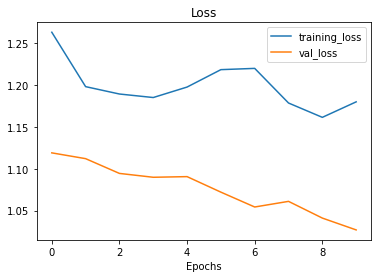

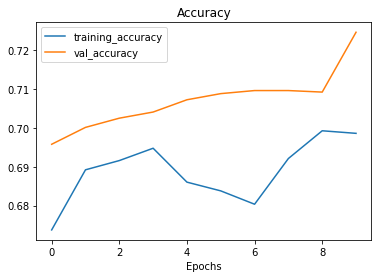

In [24]:
plot_loss_curves(history)